In [1]:
import pandas as pd
import numpy as np
import os

# Path to your raw data folder
DATA_PATH = '../data/raw/'

# Load all CSVs into a dictionary
tables = {}
for file in os.listdir(DATA_PATH):
    if file.endswith('.csv'):
        name = file.replace('olist_', '').replace('_dataset.csv', '').replace('.csv', '')
        tables[name] = pd.read_csv(DATA_PATH + file)

# See what we loaded
for name, df in tables.items():
    print(f"{name:<40} {len(df):>8,} rows  |  {len(df.columns)} columns")


customers                                  99,441 rows  |  5 columns
geolocation                              1,000,163 rows  |  5 columns
orders                                     99,441 rows  |  8 columns
order_items                               112,650 rows  |  7 columns
order_payments                            103,886 rows  |  5 columns
order_reviews                              99,224 rows  |  7 columns
products                                   32,951 rows  |  9 columns
sellers                                     3,095 rows  |  4 columns
product_category_name_translation              71 rows  |  2 columns


In [3]:
# Check null percentage in every table
for name, df in tables.items():
    null_pct = (df.isnull().sum() / len(df) * 100).round(1)
    has_nulls = null_pct[null_pct > 0]
    if len(has_nulls) > 0:
        print(f"\n--- {name} ---")
        print(has_nulls.to_string())



--- orders ---
order_approved_at                0.2
order_delivered_carrier_date     1.8
order_delivered_customer_date    3.0

--- order_reviews ---
review_comment_title      88.3
review_comment_message    58.7

--- products ---
product_category_name         1.9
product_name_lenght           1.9
product_description_lenght    1.9
product_photos_qty            1.9


In [4]:
orders = tables['orders']

# First few rows
print("=== First 3 rows ===")
print(orders.head(3).to_string())

# Order status distribution
print("\n=== Order Status Distribution ===")
print(orders['order_status'].value_counts())

# Convert purchase timestamp to datetime
orders['order_purchase_timestamp'] = pd.to_datetime(
    orders['order_purchase_timestamp']
)

# Date range of data
print("\n=== Date Range ===")
print("Earliest order:", orders['order_purchase_timestamp'].min())
print("Latest order:  ", orders['order_purchase_timestamp'].max())
print("Total months:  ",
      orders['order_purchase_timestamp'].dt.to_period('M').nunique())


=== First 3 rows ===
                           order_id                       customer_id order_status order_purchase_timestamp    order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15          2017-10-04 19:55:00           2017-10-10 21:25:13           2017-10-18 00:00:00
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27          2018-07-26 14:31:00           2018-08-07 15:27:45           2018-08-13 00:00:00
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23          2018-08-08 13:50:00           2018-08-17 18:06:29           2018-09-04 00:00:00

=== Order Status Distribution ===
order_status
delivered      96478
shipped         1107
canceled         

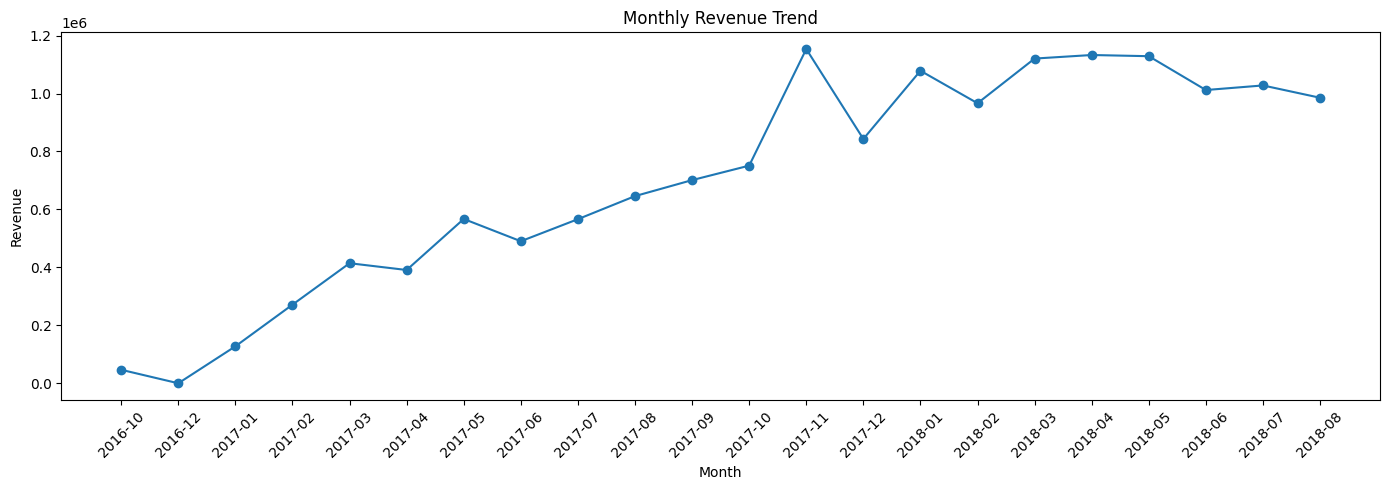

Peak month revenue: 1153528.05
Total revenue: 15422461.769999998


In [5]:
import matplotlib.pyplot as plt

payments = tables['order_payments']

# Join orders + payments
orders_pay = orders.merge(payments, on='order_id', how='inner')

# Keep only delivered orders
orders_pay = orders_pay[orders_pay['order_status'] == 'delivered']

# Extract month
orders_pay['month'] = orders_pay['order_purchase_timestamp'].dt.to_period('M')

monthly_rev = (
    orders_pay
    .groupby('month')['payment_value']
    .sum()
    .reset_index()
)

monthly_rev['month'] = monthly_rev['month'].astype(str)

# Plot monthly revenue
plt.figure(figsize=(14,5))
plt.plot(monthly_rev['month'], monthly_rev['payment_value'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue Trend')
plt.tight_layout()
plt.show()

print("Peak month revenue:", monthly_rev['payment_value'].max())
print("Total revenue:", monthly_rev['payment_value'].sum())


In [6]:
items = tables['order_items']
products = tables['products']
trans = tables['product_category_name_translation']

# Join orders + items + products + translation
merged = (
    orders_pay
    .merge(items, on='order_id')
    .merge(products, on='product_id')
    .merge(trans, on='product_category_name', how='left')
)

# Revenue by category (English)
cat_rev = (
    merged
    .groupby('product_category_name_english')['payment_value']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

print(cat_rev)


product_category_name_english
bed_bath_table           1692714.28
health_beauty            1620684.04
computers_accessories    1549372.59
furniture_decor          1394466.93
watches_gifts            1387362.45
sports_leisure           1349446.93
housewares               1069787.97
auto                      833745.67
garden_tools              810614.93
cool_stuff                744649.32
Name: payment_value, dtype: float64


In [7]:
summary = f"""
DATA EXPLORATION SUMMARY
=======================
Total Orders: {len(orders):,}
Delivered Orders: {(orders['order_status']=='delivered').sum():,}
Date Range: Sep 2016 – Oct 2018 (25 months)

Total Revenue: R$ {monthly_rev['payment_value'].sum():,.2f}
Peak Month Revenue: R$ {monthly_rev['payment_value'].max():,.2f}

Top Categories by Revenue:
{cat_rev.to_string()}
"""

with open('../docs/exploration_summary.txt', 'w') as f:
    f.write(summary)

print(summary)
print("Saved to docs/exploration_summary.txt")



DATA EXPLORATION SUMMARY
Total Orders: 99,441
Delivered Orders: 96,478
Date Range: Sep 2016 – Oct 2018 (25 months)

Total Revenue: R$ 15,422,461.77
Peak Month Revenue: R$ 1,153,528.05

Top Categories by Revenue:
product_category_name_english
bed_bath_table           1692714.28
health_beauty            1620684.04
computers_accessories    1549372.59
furniture_decor          1394466.93
watches_gifts            1387362.45
sports_leisure           1349446.93
housewares               1069787.97
auto                      833745.67
garden_tools              810614.93
cool_stuff                744649.32

Saved to docs/exploration_summary.txt
